In [29]:
import pandas as pd
import datasist as ds
import numpy as np
from pydub import AudioSegment
import math
import librosa
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa.display
from sklearn import preprocessing
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [30]:
df=pd.read_csv('Standardized_Features.csv')
df.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,label
0,0.282728,-0.474545,-1.431620,-0.838590,-1.296439,-1.893429,-1.771372,-0.975644,-1.693050,-0.905051,-2.385454,-0.195656,-1.897900,-0.203286,0.483809,-0.393816,0.077136,0.846385,1
1,1.193171,-1.450861,0.000711,-0.790228,1.279287,0.755650,0.901923,1.356368,2.278842,1.350389,1.535524,1.345042,1.197492,1.985103,1.772678,1.661541,1.866492,0.415296,0
2,-1.034973,0.627078,0.199520,0.998984,-0.784622,1.528109,-0.577994,1.107375,-0.706535,0.982741,-0.397005,-0.912998,0.486108,-1.381268,-0.979375,-1.090882,-1.125755,-1.226060,0
3,1.384008,0.560417,0.667361,-0.254236,0.610491,0.620806,0.811242,0.099781,-0.245145,1.018141,-0.216337,2.221808,0.605855,0.687013,-0.664155,-0.353625,-0.733579,-0.766253,1
4,0.934085,2.136934,-2.251532,0.690264,-1.076940,-0.852905,0.001930,-0.603969,0.854139,0.591720,0.474665,-1.057779,0.405189,-1.209908,-1.625381,-1.950325,-1.546935,-1.381914,0


# Train-test split

In [31]:
X=df.iloc[:,:13]
y=df.iloc[:,-1]
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [32]:
X_train.shape

(15507, 13)

In [33]:
## Changing dimension for  model
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [34]:
x_traincnn.shape

(15507, 13, 1)

# ANN

In [8]:
def Model(layers):
    model = Sequential()
    model.add(Dense(13, activation='relu', input_shape=(13,)))
    
    for nodes in layers:
        model.add(Dense(nodes, activation='relu'))
        model.add(Dropout(0.5))
           
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
layers=[
    # One hidden layer
    [12],
    [8],
    [20],
    # Two hidden layers
    [12,12],
    [8,8],
    [20,20],
    # Three hidden layers
    [12,12,12],
    [8,8,8],
    [20,20,20],
#      # four hidden layers
#     [12,12,12,12],
#     [8,8,8,8],
#     [20,20,20,20]
    
]
model = KerasClassifier(build_fn=Model, verbose=0)
#param_grid=dict(layers=layers, batch_size=[1723],epochs=[100,200,500,1000,1500,2000])
param_grid=dict(layers=layers, batch_size=[1723],epochs=[1000,1500])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
es = EarlyStopping(monitor='val_loss', mode='min')
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Amit\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Best: 0.688012 using {'batch_size': 1723, 'epochs': 1000, 'layers': [20]}


In [21]:
y_pred = grid.predict(X_test)
accuracy_score(y_test, y_pred)

0.6947185142193848

Confusion matrix:
[[770 168]
 [358 427]]



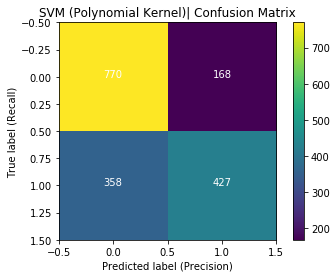

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
clf_cfm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(clf_cfm, end='\n\n')
import matplotlib.pyplot as plt
import itertools
plt.imshow(clf_cfm, interpolation='nearest')

for i, j in itertools.product(range(clf_cfm.shape[0]), range(clf_cfm.shape[1])):
    plt.text(j, i, clf_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('SVM (Polynomial Kernel)| Confusion Matrix')
plt.colorbar();

In [22]:
params = grid_result.best_params_
es = EarlyStopping(monitor='val_loss', mode='min')
## create the model with the best params found
model = Model(layers=params['layers'])

## Then train it and display the results
history = model.fit(X_train,
                    y_train,
                    epochs=params['epochs'],
                    batch_size=params['batch_size'],
                    verbose = 0,
                 validation_data=(X_test, y_test),
                  shuffle=True,
                   callbacks=[es])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                280       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________


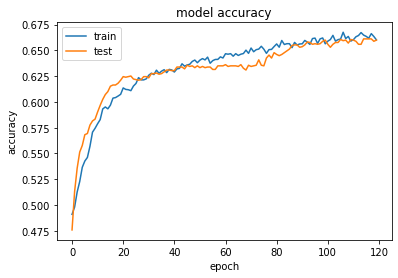

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

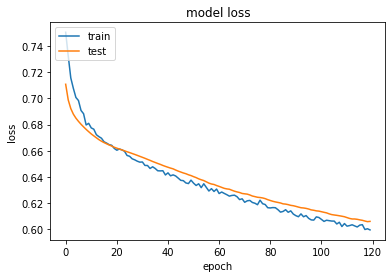

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN

In [35]:
from keras.layers import Dense, Conv1D,Flatten

model = Sequential()
model.add(Conv1D(32, 3, activation="relu", input_shape=(x_traincnn.shape[1:]),padding='same'))
#model.add(MaxPooling1D(pool_size=(16)))
model.add(Conv1D(32, 3, activation="relu",padding='same'))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 13, 32)            128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 32)            3104      
_________________________________________________________________
flatten_3 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                26688     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 29,985
Trainable params: 29,985
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', 
              optimizer= Adam(lr=0.00001, decay=1e-6), 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min')
history=model.fit(x_traincnn, y_train, 
          batch_size=9,
          epochs=200, 
          verbose=0,
         validation_data=(x_testcnn, y_test),
              shuffle=True,
                 callbacks=[es])

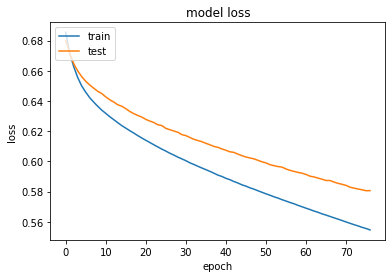

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

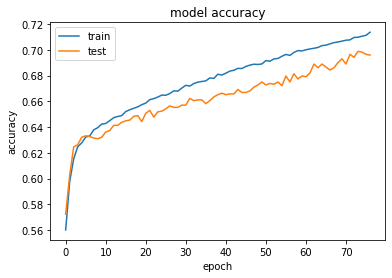

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()